
## Title: Concrete Wall Crack Detection

Author: Pi

Date created: 12 March 2021

Description: Training an image classifier from to detect cracks on concrete walls.


In [1]:
## Setup

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
# Filter out corrupted images from the training data

import os

num_skipped = 0
for folder_name in ("Negative", "Positive"):
    folder_path = os.path.join("Data", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [4]:
## Generate dataset

image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Data",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Data",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 40000 files belonging to 2 classes.
Using 32000 files for training.
Found 40000 files belonging to 2 classes.
Using 8000 files for validation.


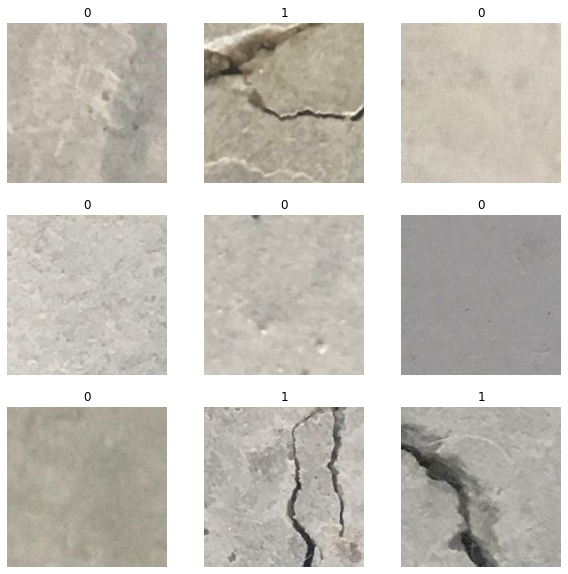

In [5]:
# Visualizing the data
# The images labelled 1 contains crack 
# and the ones labelled 0 are smooth
    
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [6]:
# Introduce diversity into the image dataset by rotating some of the images
    
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

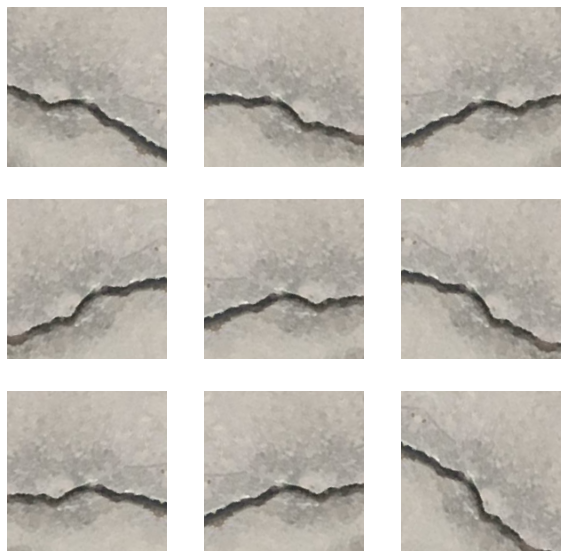

In [7]:
# Let's visualizing the augmented samples

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
# Configure dataset for performance

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


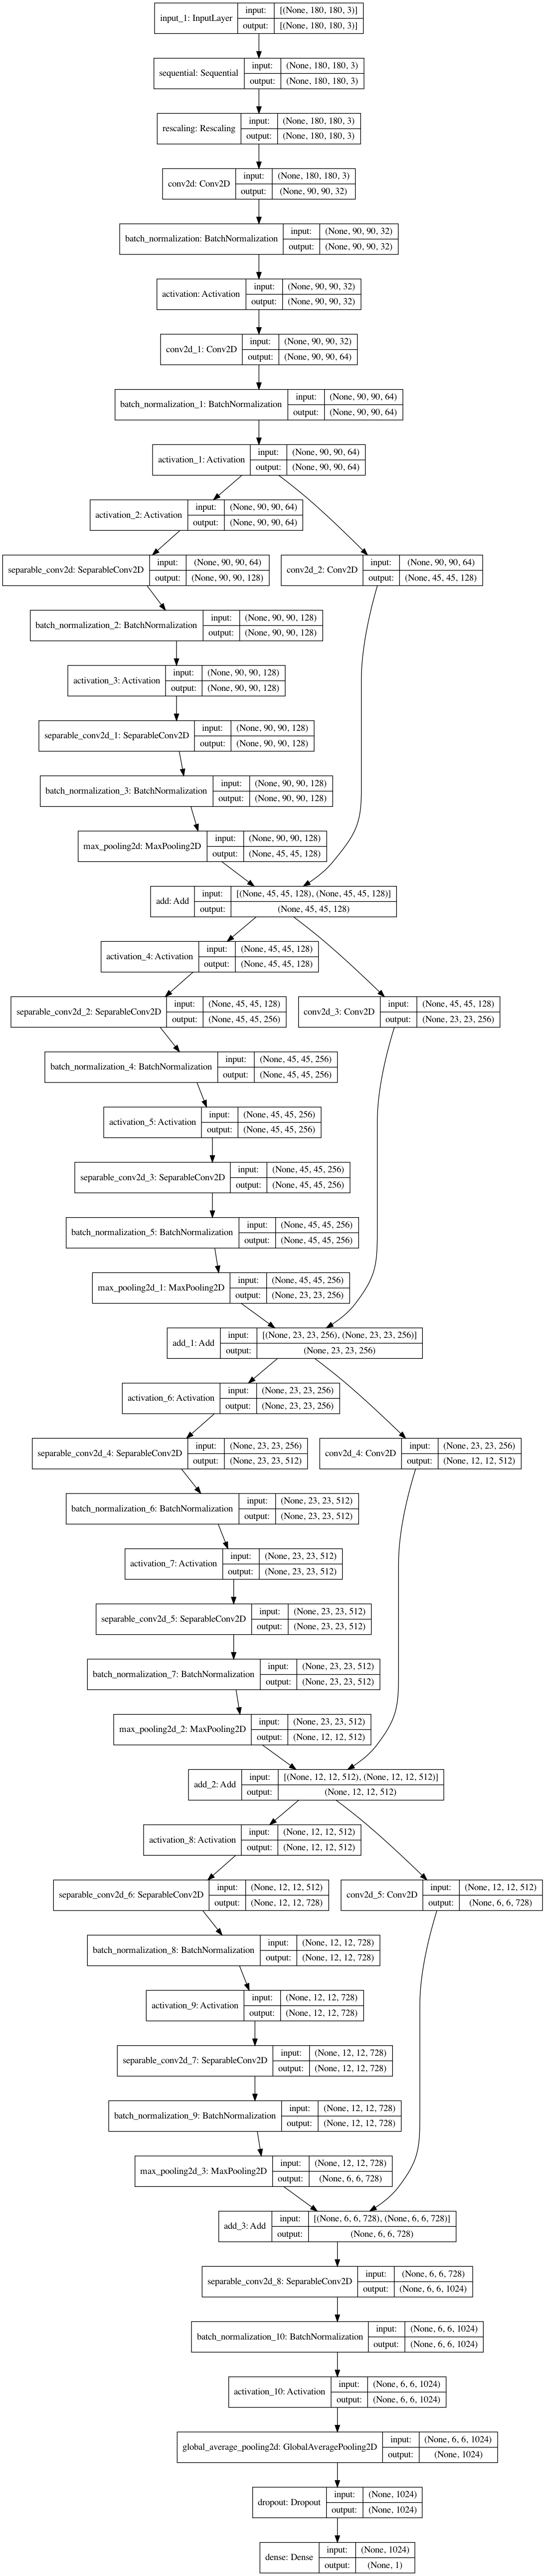

In [9]:
## Build a model

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Train the model with 2 epochs for temporary results

epochs = 2

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/2
 149/1000 [===>..........................] - ETA: 48:01 - loss: 0.1139 - accuracy: 0.9444

In [ ]:
# save model and architecture to single file
model.save("wallcrackdetection.h5")
print("Saved model to disk")

In [4]:
# Image Analysis
# Code from here to bottom is reusable


from PIL import Image, ImageDraw,ImageColor
from IPython.display import clear_output

from itertools import product
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import math
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# Use a pretrained Model - comment line below if training a new model

model = keras.models.load_model('wallcrackdetection.h5')
# model.summary()
# -----------------------------------------------------------


filename_to_analyze = "texture_1001.png"
tile_resolution = 20
marker_width = 3
confidence_interval= 85


def tile(filename, dir_in, dir_out, d):
    name, ext = os.path.splitext(filename)
    img = Image.open(os.path.join(dir_in, filename))
    w, h = img.size
    
    grid = list(product(range(0, h-h%d, d), range(0, w-w%d, d)))
    for i, j in grid:
        box = (j, i, j+d, i+d)
        out = os.path.join(dir_out, f'{int(i/d)}_{int(j/d)}{ext}')
        img.crop(box).save(out)
        # i is vertical column count
        # j is horizontal row count
        row = int(j/d)
        column = int(j/d)
        
print("Splitting Images")
tile(filename_to_analyze,"input","splitted",tile_resolution)


# Rebuild grid image
print("Rebuilding Grid Image")
# Config:
images_dir = 'splitted'
name, ext = os.path.splitext(filename_to_analyze)
result_grid_filename = './output/'+name+'.jpg'
result_figsize_resolution = 10 # 1 = 100px

images_list = os.listdir(images_dir)
images_count = len(images_list)
if '.DS_Store' in images_list:
    images_list.remove('.DS_Store')

# get row and column count
def get_row(filename, dir_in, dir_out, d):
    name, ext = os.path.splitext(filename)
    img = Image.open(os.path.join(dir_in, filename))
    w, h = img.size
    grid = list(product(range(0, h-h%d, d), range(0, w-w%d, d)))
    for i, j in grid:
        box = (j, i, j+d, i+d)
        row = int(j/d)
    return row+1
def get_column(filename, dir_in, dir_out, d):
    name, ext = os.path.splitext(filename)
    img = Image.open(os.path.join(dir_in, filename))
    w, h = img.size
    grid = list(product(range(0, h-h%d, d), range(0, w-w%d, d)))
    for i, j in grid:
        box = (j, i, j+d, i+d)
        column = int(i/d)
    return column+1


row = get_row(filename_to_analyze,"input","splitted",tile_resolution)

column = get_column(filename_to_analyze,"input","splitted",tile_resolution)


# Calculate the grid size:
grid_size = math.ceil(math.sqrt(images_count))

# Create plt plot:

fig, axes = plt.subplots(column,row, figsize=(row*3,column*3))

current_file_number = 0
i = 0
j = 0

while i < row:
    while j < column:
        x_position = current_file_number % column
        y_position = current_file_number // column
        name, ext = os.path.splitext(images_list[current_file_number])
        # print( str(j) + '_' +str(i)+ext)
        
        current_filename = images_dir + '/' + str(j) + '_' +str(i)+ext

        # analyze all the images in the splitted arrays
        clear_output(wait=True)
        percent = (current_file_number / (row*column))*100
        print(str(int(percent))+"% - Analyzing Crack for "+current_filename)
        image_size = (180, 180)
        img = keras.preprocessing.image.load_img(
            current_filename, target_size=image_size
        )
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)

        predictions = model.predict(img_array)
        score = predictions[0]

        smooth_score = 100 * (1 - score)
        crack_score = 100 * score

        # print("This wall is %.2f percent smooth and %.2f percent cracked."% (smooth_score,crack_score))

        if(crack_score >= confidence_interval):
            #print("Crack Detected with confidence "+str(crack_score)+" at "+ current_filename) 
            # Manipulate Image According to crackscore
            img = Image.open(current_filename)
            with Image.open(current_filename) as im:

                draw = ImageDraw.Draw(im)
                # Draw Red square grid over Cracks
                draw.line((0, 0,im.size[0],0,im.size[0],im.size[1],0,img.size[1],0,0), fill=ImageColor.getrgb("red"),width=marker_width)
                # write to output file
                im.save(current_filename)

        # Analysis Done
        
        plt_image = plt.imread(current_filename)
        axes[x_position, y_position].imshow(plt_image)
        axes[x_position, y_position].axis("off")
        current_file_number += 1
        j+= 1
    j=0
    i += 1
    
print("Rendering final image")
plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0,hspace=0,wspace=0)
plt.savefig(result_grid_filename)

# Clear the splitted files after the process
dir = "./splitted/"
for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

99% - Analyzing Crack for splitted/50_50.png
Rendering final image
